## (In)elastic analysis

In [1]:
%load_ext autoreload
%autoreload 2
import pyphysics as phys

import pandas as pd
import uproot
import hist
import matplotlib.pyplot as plt
import ROOT as r


df = pd.read_csv("./sidesil.csv")

<Axes: xlabel='Rec status', ylabel='Counts'>

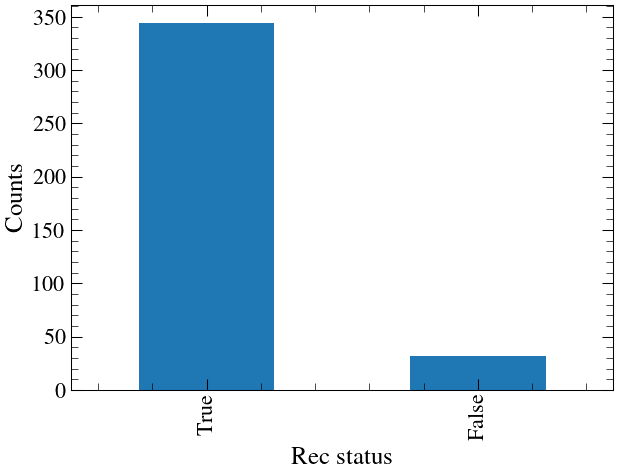

In [2]:
bina = df[df["type"] == "Binary"]

bina["status"].value_counts().plot.bar(xlabel="Rec status", ylabel="Counts")


In [3]:
# Read root file
data = uproot.open("../../../Macros/PID/Outputs/sidesil.root:SimpleTree")
root = data.arrays(library="pd")
root["fRun"] = root["fRun"].astype(int)
root["fEntry"] = root["fEntry"].astype(int)


<Axes: title={'center': 'OK reconstructed'}, xlabel='Silicon index'>

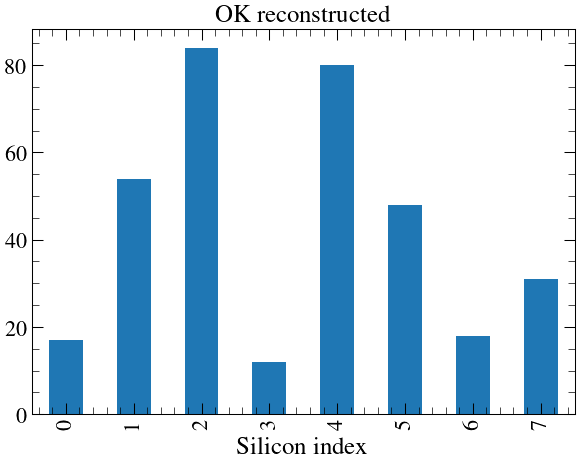

In [4]:
# Plot of distribution by silicon index
true = bina[bina["status"] == True]
root.loc[true.index, "N0"].value_counts().sort_index().plot.bar(title="OK reconstructed", xlabel="Silicon index")

<Axes: title={'center': 'Badly reconstructed'}, xlabel='Silicon index'>

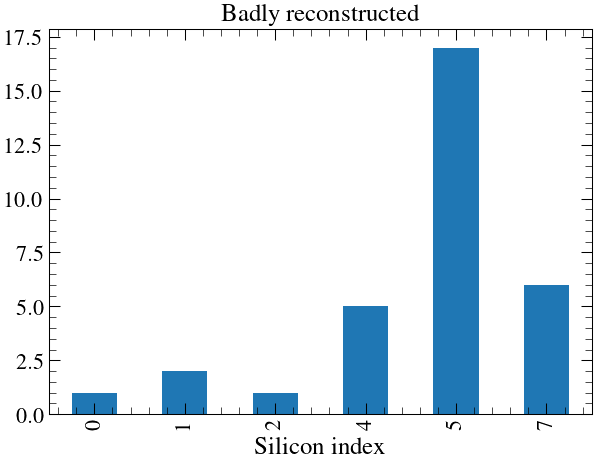

In [5]:
false = bina[bina["status"] == False]
root.loc[false.index, "N0"].value_counts().sort_index().plot.bar(title="Badly reconstructed", xlabel="Silicon index")

In [6]:
hBadE = hist.Hist(hist.axis.Regular(50, 0, 10, name="ESil0", label="ESil0 [MeV]"))
hBadE.fill(root.loc[false.index, "E0"].values)

Hist(Regular(50, 0, 10, name='ESil0', label='ESil0 [MeV]'), storage=Double()) # Sum: 32.0

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7b1408162830>, errorbar=None, legend_artist=None)]

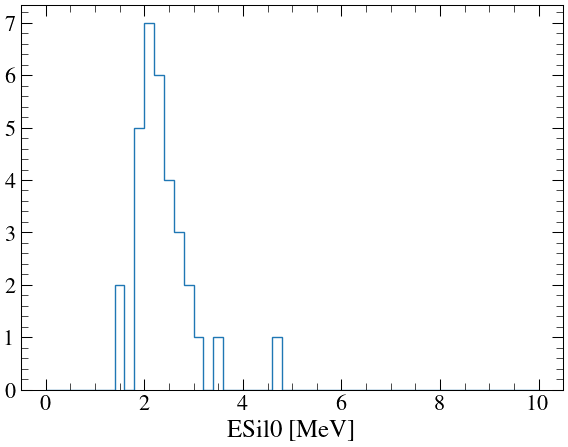

In [7]:
hBadE.plot1d(yerr=False)

In [8]:
dataman = phys.DataManInterface("../../../configs/data.conf", "tpc", (155, 165))
tpc = r.ActRoot.TPCData()
dataman.set_branch_address("TPCData", tpc)

In [9]:
def fit_upper(tpc: r.ActRoot.TPCData)-> float: #type: ignore
    voxels = []
    ycut = (80, 120)
    # Noise
    for v in tpc.fRaw:
        y = v.GetPosition().Y()
        if ycut[0] <= y <= ycut[1]:
            voxels.append(v)
    # Clusters
    for c in tpc.fClusters:
        for v in c.GetVoxels():
            y = v.GetPosition().Y()
            if ycut[0] <= y <= ycut[1]:
                voxels.append(v)
    # Fit
    line = r.ActRoot.Line() #type:ignore
    line.FitVoxels(voxels)
    # Angle
    beam = r.Math.XYZVector(1, 0, 0)
    dot = line.GetDirection().Unit().Dot(beam)
    theta = r.TMath.ACos(dot) * r.TMath.RadToDeg()
    return theta


angles = []
for i in false.index:
    run, entry = root.at[i, "fRun"], root.at[i, "fEntry"]
    dataman.get_run_entry(run, entry)
    theta = fit_upper(tpc)
    print(f"i {i} Run {int(run)} Entry {entry} theta : {theta:.2f}")
    


i 37 Run 155 Entry 3599 theta : 140.87
i 65 Run 155 Entry 5463 theta : 4.49
i 80 Run 155 Entry 6667 theta : 66.41
i 127 Run 155 Entry 11202 theta : 12.38
i 140 Run 155 Entry 12142 theta : 16.84
i 168 Run 155 Entry 15005 theta : 140.49
i 179 Run 155 Entry 16200 theta : 19.97
i 183 Run 155 Entry 16792 theta : 2.32
i 233 Run 155 Entry 21265 theta : 6.85
i 287 Run 155 Entry 25307 theta : 91.88
i 292 Run 155 Entry 25735 theta : 37.45
i 341 Run 155 Entry 28872 theta : 13.28
i 356 Run 155 Entry 31386 theta : 34.67
i 365 Run 155 Entry 32139 theta : 31.95
i 415 Run 155 Entry 35856 theta : 28.03
i 432 Run 155 Entry 37292 theta : 90.88
i 450 Run 156 Entry 1460 theta : 17.49
i 456 Run 156 Entry 1879 theta : 7.80
i 514 Run 156 Entry 5645 theta : 4.82
i 550 Run 156 Entry 8632 theta : 32.92
i 567 Run 156 Entry 9891 theta : 93.05
i 617 Run 156 Entry 13950 theta : 29.79
i 633 Run 156 Entry 15558 theta : 12.22
i 639 Run 156 Entry 15849 theta : 54.42
i 670 Run 156 Entry 18337 theta : 35.43
i 694 Run 156 

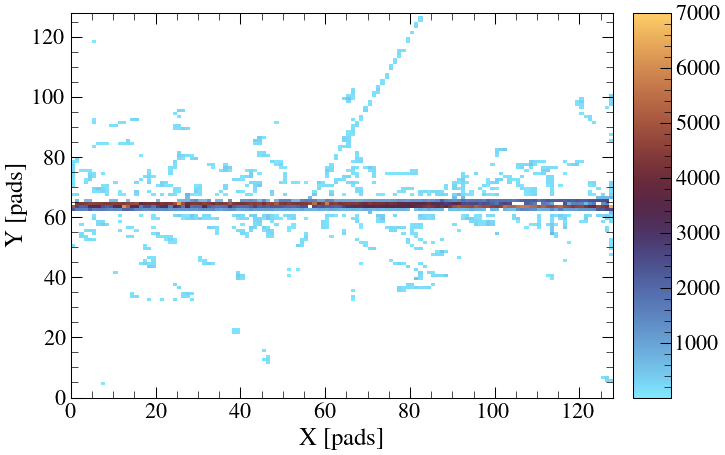

In [21]:
aux = phys.TPCInterface(tpc)
aux.plot()

In [11]:
def plot(tpc):
    h = hist.Hist.new.Reg(128, 0, 128, name="X", label="X [pads]").Reg(128, 0, 128, name="Y", label="Y [pads]").Double()
    # Noise
    for v in tpc.fRaw:
        pos = v.GetPosition()
        h.fill(pos.X(), pos.Y(), weight=v.GetCharge())
    # Clusters
    for c in tpc.fClusters:
        for v in c.GetVoxels():
            pos = v.GetPosition()
            h.fill(pos.X(), pos.Y(), weight=v.GetCharge())
    h.plot(cmin=1, cmax=5000)

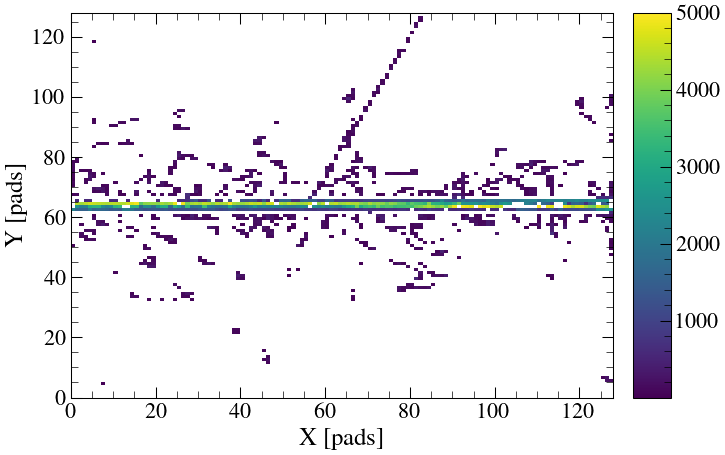

In [12]:
plot(tpc)

In [13]:
root

,fRun,fEntry,E0,N0
0,155,58,3.486994,4
1,155,222,1.936626,6
2,155,295,2.136457,4
3,155,426,3.332102,3
4,155,630,1.732933,5
...,...,...,...,...
7356,165,54915,2.685698,7
7357,165,55074,2.738557,5
7358,165,55174,5.099133,4
7359,165,55237,1.834418,7


In [14]:
root.loc[0, ["fEntry"]]

fEntry    58.0
Name: 0, dtype: float64